## Downlink Max Throughput 

[41.32 95.43 98.2  48.83 47.11 61.61]


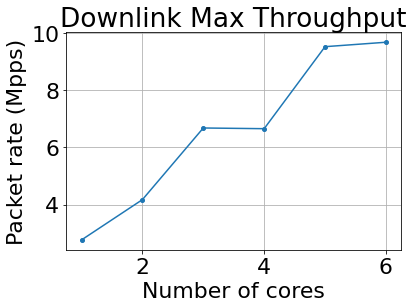

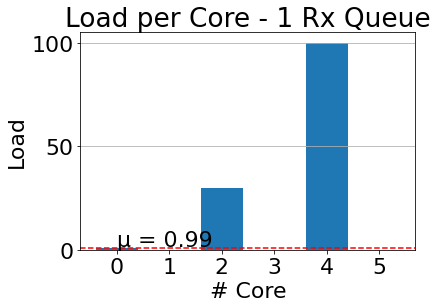

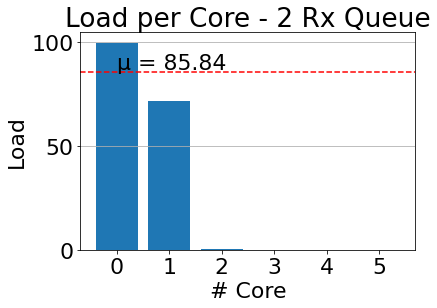

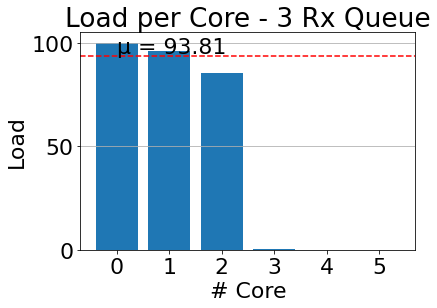

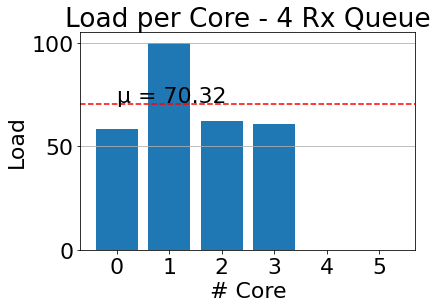

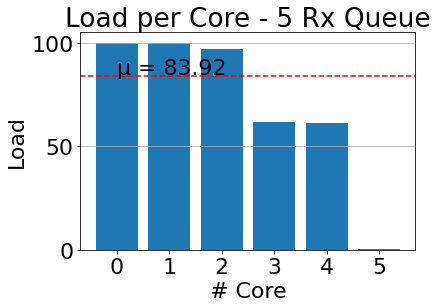

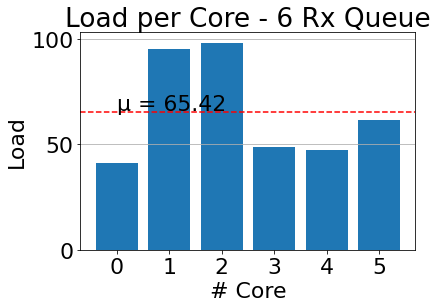

In [7]:
import json
import numpy as np
import matplotlib.pyplot as plt

# increase font size
plt.rcParams.update({'font.size': 22})

def get_throughputs(dict_output):
    array = []
    for item in dict_output["items"]:
        array.append(item["throughput"])
    return np.array(array)

def get_soft_loads(dict_output):
    matriz = []
    for item in dict_output["items"]:
        array = []
        ids = []
        for i, cpu_load in enumerate(item["mpstat"]["sysstat"]["hosts"][0]["statistics"][0]["cpu-load"]):
            array.append(cpu_load["soft"])
            # It will override each iteraction. 
            ids.append(cpu_load["cpu"])
        matriz.append(array)
    return np.array(matriz), np.array(ids)


reports_path = "tests/reports"
img_path = os.path.join(reports_path, "img")

filename = os.path.join(reports_path, "DownlinkMaxThoughtput.json")
test_title = 'Downlink Max Throughput'
# filename = os.path.join(reports_path, "UplinkMaxThoughtput.json")
# test_title = 'Uplink Max Throughput'

with open(filename,"r") as report:
    dict_output = json.load(report)
    y = get_throughputs(dict_output)
    y_loads, ids = get_soft_loads(dict_output)

x = np.arange(1, len(y_loads) + 1, 1)

fig, ax = plt.subplots()
ax.plot(x, y, 'o', ls='-', ms=4)

ax.set(xlabel='Number of cores', ylabel='Packet rate (Mpps)',
       title=test_title)
ax.grid()
plt.savefig(os.path.join(img_path, test_title))

n_tests , _= y_loads.shape
for i, y_load in enumerate(y_loads, 1):   
    fig2, ax = plt.subplots()    
    # Skip cpu "all"
    y = y_load[1:]
    x = ids[1:]
    ax.bar(x, y)
    mean = round(np.mean(y[:i]),2)
    plt.axhline(mean, color="red", linestyle="--")
    ax.text(0, mean + 1, "μ = {}".format(mean),  bbox=dict(boxstyle="round", ec=(1., 0.5, 0.5), fc=(1., 0.8, 0.8),))
    load_title = 'Load per Core - {} Rx Queue'.format(i) 
    ax.set(xlabel='# Core', ylabel='Load',
       title=load_title)
    ax.yaxis.grid()
    plt.savefig(os.path.join(img_path, test_title + load_title))


print (y)


## Uplink Max Throughput